# Creador de videos

In [1]:
# %% [code]

### make sure that CUDA is available in Edit -> Nootbook settings -> GPU
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader


# Instalación de dependencias necesarias (Puede que alguna sobre en la version final, pero al menos no faltan)
!pip install moviepy gradio elevenlabs pillow pydub
!pip install git+https://github.com/openai/whisper.git

!pip install --upgrade diffusers transformers accelerate safetensors
!pip install --upgrade torch torchvision --extra-index-url https://download.pytorch.org/whl/cu117

!apt install imagemagick
!apt install libmagick++-dev
!cat /etc/ImageMagick-6/policy.xml | sed 's/none/read,write/g'> /etc/ImageMagick-6/policy.xml
!pip install srt
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q ffmpeg-python

# Actualizar yt-dlp a la última versión
!pip install -U yt-dlp


#Programa SadTalker

### make sure that CUDA is available in Edit -> Nootbook settings -> GPU
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader



!pip install pydub

!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.8 2
!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.9 1
!sudo apt install python3.8

!sudo apt-get install python3.8-distutils

!python --version

!apt-get update

!apt install software-properties-common

!sudo dpkg --remove --force-remove-reinstreq python3-pip python3-setuptools python3-wheel

!apt-get install python3-pip

print('Git clone project and install requirements...')
!git clone https://github.com/Winfredy/SadTalker &> /dev/null
%cd SadTalker
!export PYTHONPATH=/content/SadTalker:$PYTHONPATH
!python3.8 -m pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!apt update
!apt install ffmpeg &> /dev/null
!python3.8 -m pip install -r requirements.txt

print('Download pre-trained models...')
!rm -rf checkpoints
!bash scripts/download_models.sh

Tesla T4, 15360 MiB, 15095 MiB
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.5/347.5 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-n5oxyfqo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-n5oxyfqo
  Resolved https://github.com/openai/whisper.git to commit 517a43ecd132a2089d85f4ebc044728a71d49f6e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproj

In [ ]:
# -------------------------------
# Importaciones y Configuración
# -------------------------------

import os
import gc
import time
import re
import threading

import torch
import gradio as gr
from transformers import AutoModelForCausalLM, AutoTokenizer
from elevenlabs.client import ElevenLabs
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler
from moviepy.editor import ImageClip, AudioFileClip, concatenate_videoclips
import whisper
from google import genai

# -------------------------------
# VARIABLES GLOBALES: API KEYS
# -------------------------------
API_KEY_GENAI = "TU KEY"    # https://aistudio.google.com/app/apikey
API_KEY_ELEVENLABS = "TU KEY"    # https://elevenlabs.io/app/settings/api-keys

# -------------------------------
# Variables globales de control y configuración
# -------------------------------
salir_flag = False
VOZ_DISPONIBLES = ["Rachel", "Domi", "Antoni", "Josh", "Bella"]
MODELO_AUDIO = "eleven_multilingual_v2"
ESTILOS_DISPONIBLES = ["Realista", "Anime", "Cinemático", "Pintura Digital"]


#IMPORTANTE
os.chdir("/content")

def validar_voz(voice):
    """Valida que la voz exista; si no, retorna la voz por defecto 'Rachel'."""
    if voice not in VOZ_DISPONIBLES:
        print(f"Voice {voice} not found. Usando voz por defecto 'Rachel'")
        return "Rachel"
    return voice

def generar_nuevo_video(dialogo_editado, imagenes_editadas, voice, estilo):
    """
    Llama a la función principal que crea el video, y retorna:
     - la ruta del video (para descarga),
     - la ruta del archivo de subtítulos,
     - el guion final reensamblado (con cada línea: "Diálogo. (Imagen).").
    """
    archivo_video, archivo_subtitulos, guion_final = generar_video_con_guion(dialogo_editado, imagenes_editadas, voice, estilo)
    return archivo_video, archivo_subtitulos, guion_final

# -------------------------------
# 1. Generación de Guion (texto)
# -------------------------------
client_text = genai.Client(api_key=API_KEY_GENAI)
def generar_guion(tema):
    prompt = (
        f"Escribe un guion explicativo y resumido sobre {tema}, con tono educativo, para un video en redes sociales. "
        "El texto debe ser narrativo, sin secciones, numeraciones ni instrucciones visuales, y debe utilizar comas, tildes, puntos "
        "y signos de exclamación de forma correcta. No incluyas mensajes adicionales ni elementos estructurales, solo el guion en texto plano. "
        "Debe haber un punto aparte al final de cada oración, o después del final de un signo de interrogación o exclamación. "
        "El video debe ser pegadizo y arrancar con algún gancho novedoso, como '¿Sabías que?'. "
        "Además, cada línea del guion debe tener el siguiente formato: Texto. (Imagen). Es decir, después de cada segmento de diálogo se "
        "debe colocar, entre paréntesis, la descripción de la imagen correspondiente, resumida en máximo 5 palabras, y luego iniciar un nuevo párrafo."
        "No incluyas texto: o imagen:"
    )
    response = client_text.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt,
    )
    return response.text

# Función para dividir el guion generado en dos partes: diálogo e imágenes
def split_guion(guion_completo):
    lines = guion_completo.splitlines()
    dialogue_lines = []
    image_lines = []
    for line in lines:
        line = line.strip()
        if len(line) < 5:
            continue
        # Extraer diálogo: eliminar lo que está entre paréntesis
        dialogue = re.sub(r'\s*\(.*?\)', '', line).strip()
        # Extraer imagen: el contenido dentro de los paréntesis
        match = re.search(r'\((.*?)\)', line)
        image_prompt = match.group(1).strip() if match else ""
        dialogue_lines.append(dialogue)
        image_lines.append(image_prompt)
    return "\n".join(dialogue_lines), "\n".join(image_lines)

# -------------------------------
# 2. Conversión de Guion a Voz (ElevenLabs)
# -------------------------------
client_audio = ElevenLabs(api_key=API_KEY_ELEVENLABS)

def generar_audio(texto, voice="Rachel", archivo_salida="audio.mp3"):
    voice = validar_voz(voice)
    audio_generator = client_audio.generate(
        text=texto,
        voice=voice,
        model=MODELO_AUDIO
    )
    with open(archivo_salida, "wb") as f:
        for chunk in audio_generator:
            f.write(chunk)
    return archivo_salida

def preview_voice(voice):
    """Genera un archivo de audio y retorna su ruta (solo para descarga)."""
    voice = validar_voz(voice)
    preview_text = "Hola, soy la voz que elegiste"
    archivo_preview = "preview_audio.mp3"
    audio_generator = client_audio.generate(
        text=preview_text,
        voice=voice,
        model=MODELO_AUDIO
    )
    with open(archivo_preview, "wb") as f:
        for chunk in audio_generator:
            f.write(chunk)
    return os.path.abspath(archivo_preview)

# -------------------------------
# 3. Generación de Imagen con Stable Diffusion
# -------------------------------
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    variant="fp16"
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")
pipe.enable_attention_slicing()

def generar_imagen(prompt, estilo, archivo_salida="imagen.png"):
    prompt_mejorado = (
        f"Generar una imagen en estilo {estilo.lower()}, altamente detallada y sin errores anatómicos. "
        f"La imagen debe representar lo siguiente: {prompt}. "
        f"Iluminación natural, alta resolución, texturas realistas."
    )
    with torch.no_grad():
        resultado = pipe(prompt_mejorado, guidance_scale=8.0, num_inference_steps=50)
        imagen = resultado.images[0]
    imagen.save(archivo_salida)
    del imagen
    torch.cuda.empty_cache()
    gc.collect()
    return archivo_salida

# -------------------------------
# 4. Edición y Ensamblaje del Video con MoviePy
# -------------------------------
def crear_video(imagenes, audio, salida="video.mp4", duracion_por_imagen=5):
    clips = [ImageClip(img).set_duration(duracion_por_imagen) for img in imagenes]
    video = concatenate_videoclips(clips, method="compose")
    audio_clip = AudioFileClip(audio)
    video = video.set_audio(audio_clip)
    video.write_videofile(salida, fps=24)
    return salida

# -------------------------------
# 5. Generación de Subtítulos con Whisper
# -------------------------------
model_whisper = whisper.load_model("medium")

def generar_subtitulos(audio_file, subtitulo_salida="subtitulos.srt"):
    resultado = model_whisper.transcribe(audio_file)
    with open(subtitulo_salida, "w", encoding="utf-8") as f:
        f.write(resultado["text"])
    return subtitulo_salida

# -------------------------------
# 6. Función Global para Generar Video a partir del Guion Editado
# -------------------------------
def generar_video_con_guion(dialogo_editado, imagenes_editadas, voice="Rachel", estilo="Realista"):
    # Separar líneas (ignorando las que tengan menos de 5 caracteres)
    dialogue_lines = [line.strip() for line in dialogo_editado.splitlines() if len(line.strip()) >= 5]
    image_lines = [line.strip() for line in imagenes_editadas.splitlines() if len(line.strip()) >= 5]

    # Asegurar que se usen la misma cantidad de líneas (se toma el mínimo)
    num_lines = min(len(dialogue_lines), len(image_lines))
    dialogue_lines = dialogue_lines[:num_lines]
    image_lines = image_lines[:num_lines]

    # Reensamblar el guion final para mostrarlo (cada línea: "Diálogo. (Imagen).")
    guion_final_lines = []
    for d, i in zip(dialogue_lines, image_lines):
        guion_final_lines.append(f"{d}. ({i}).")
    guion_final = "\n".join(guion_final_lines)

    # Generar audio a partir del diálogo editado (se unen todas las líneas)
    final_dialogue_text = " ".join(dialogue_lines)
    archivo_audio = generar_audio(final_dialogue_text, voice=voice)

    # Calcular duración para cada imagen según la duración total del audio
    duracion_audio = AudioFileClip(archivo_audio).duration
    duracion_por_imagen = duracion_audio / num_lines if num_lines > 0 else 5

    # Generar imágenes usando las descripciones editadas
    imagenes = []
    for idx, image_prompt in enumerate(image_lines):
        archivo_imagen = f"imagen_{idx}.png"
        generar_imagen(image_prompt, estilo, archivo_salida=archivo_imagen)
        imagenes.append(archivo_imagen)

    archivo_video = crear_video(imagenes, archivo_audio, duracion_por_imagen=duracion_por_imagen)
    archivo_subtitulos = generar_subtitulos(archivo_audio)
    torch.cuda.empty_cache()
    gc.collect()

    return archivo_video, archivo_subtitulos, guion_final



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
# -------------------------------
# 7. Interfaz Gradio
# -------------------------------

import gradio as gr

def generar_y_guardar_guion(tema):
    prompt = generar_guion(tema)
    return prompt, prompt  # El primer valor actualiza el cuadro de texto; el segundo, el estado

with gr.Blocks() as demo:
    gr.Markdown("# Generador Automático de Videos Explicativos")
    gr.Markdown(
        "Flujo de trabajo:\n"
        "1. **Generar Guion:** Se genera el prompt (guion) a partir del tema.\n"
        "2. **Editar Guion:** Se carga el prompt generado, se puede editar y, al pulsar 'Dividir Guion en Diálogo e Imágenes', se separa para su edición.\n"
        "3. **Generar Video:** Se usa el diálogo e imágenes editados para generar el video final.\n\n"
        "En audio se usa el modelo **eleven_multilingual_v2** (voces: Rachel, Domi, Antoni, Josh y Bella). La preview del audio se descarga."
    )

    # Estados compartidos entre pestañas
    guion_state = gr.State()       # Guarda el prompt/guion generado
    dialogo_state = gr.State()       # Guarda el diálogo resultante
    imagenes_state = gr.State()      # Guarda las descripciones de imagen

    # ----------------------------
    # Pestaña 1: Generar Guion (Prompt)
    # ----------------------------
    with gr.Tab("Generar Guion"):
        with gr.Row():
            tema_input = gr.Textbox(label="Tema del Video", placeholder="Ej: La historia del internet")
            btn_generar = gr.Button("Generar Prompt")
        prompt_text = gr.Textbox(label="Prompt Generado", lines=5, interactive=False)
        btn_generar.click(
            fn=generar_y_guardar_guion,
            inputs=tema_input,
            outputs=[prompt_text, guion_state],
            queue=True
        )

    # ----------------------------
    # Pestaña 2: Editar Guion
    # ----------------------------
    with gr.Tab("Editar Guion"):
        # Botón para cargar el guion generado desde el estado (de la pestaña anterior)
        btn_cargar = gr.Button("Cargar Guion Generado")
        guion_editable = gr.Textbox(label="Guion Generado (editable)", lines=10)
        btn_cargar.click(fn=lambda x: x if x is not None else "", inputs=guion_state, outputs=guion_editable)

        # Botón para dividir el guion en diálogo e imágenes
        btn_split = gr.Button("Dividir Guion en Diálogo e Imágenes")
        dialogo_editable = gr.Textbox(label="Editar Diálogo", lines=10, placeholder="El diálogo resultante")
        imagenes_editable = gr.Textbox(label="Editar Imágenes", lines=10, placeholder="Descripciones (una por línea, máximo 5 palabras)")
        btn_split.click(
            fn=split_guion,
            inputs=guion_editable,
            outputs=[dialogo_editable, imagenes_editable],
            queue=True
        )
        # Actualizamos los estados con los resultados del split
        btn_split.click(lambda d, i: (d, i), inputs=[dialogo_editable, imagenes_editable], outputs=[dialogo_state, imagenes_state])

        # Actualiza estados si se editan los cuadros de texto
        btn_actualizar = gr.Button("Actualizar Guion Editado")
        btn_actualizar.click(lambda d, i: (d, i), inputs=[dialogo_editable, imagenes_editable], outputs=[dialogo_state, imagenes_state])

    # ----------------------------
    # Pestaña 3: Generar Video
    # ----------------------------
    with gr.Tab("Generar Video"):
        voice_dropdown = gr.Dropdown(label="Selecciona la Voz", choices=VOZ_DISPONIBLES, value="Rachel")
        estilo_dropdown = gr.Dropdown(label="Selecciona el Estilo de Imagen", choices=ESTILOS_DISPONIBLES, value="Realista")

        with gr.Row():
            btn_preview = gr.Button("Preview Voz")
            preview_audio_file = gr.File(label="Audio Preview (descargar)")
        btn_preview.click(
            fn=preview_voice,
            inputs=[voice_dropdown],
            outputs=preview_audio_file,
            queue=True
        )

        video_file = gr.File(label="Video Generado (.mp4)")
        subtitulos_out = gr.File(label="Subtítulos (.srt)")
        guion_final_out = gr.Textbox(label="Guion Final Reensamblado", interactive=False)
        btn_generar_video = gr.Button("Generar Video")
        btn_generar_video.click(
            fn=generar_nuevo_video,
            inputs=[dialogo_state, imagenes_state, voice_dropdown, estilo_dropdown],
            outputs=[video_file, subtitulos_out, guion_final_out],
            queue=True
        )

    demo.launch()
    #input("Para habilitar terminal debug, descoméntame....Pulsa enter para salir")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://72083100f31a703db7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# SUBTITULOS

**Recomendacion**  =
- **Utilizar una pestaña a la vez, no es concurrente**
- Si se genera un talking head, se debe reiniciar la secion para evitar que se sature (Ctrl + M )
- El generador de la talking face es muy lento (Varios minutos por 10 segundos de audio). Usar a discresion Y EVITAR VIDEOS MUY LARGOS, que se satura la RAM



In [ ]:
import os
import subprocess
import ffmpeg
import gradio as gr
import requests
import json
from pydub import AudioSegment
import shutil

# Directorios y rutas base
BASE_DIR = "/content"
SADTALKER_DIR = os.path.join(BASE_DIR, "SadTalker")
NCS_LIBRARY_DIR = os.path.join(BASE_DIR, "ncs_library")
DEFAULT_TALKING_HEAD_IMAGE = os.path.join(BASE_DIR, "default_talking_head.png")

# -------------------------------
# Funciones para la imagen default para Talking Head
# -------------------------------
def get_default_talking_head_image():
    """
    Descarga una imagen de https://thispersondoesnotexist.com/ y la guarda en /content/default_talking_head.png
    si no existe. Retorna la ruta del archivo.
    """
    file_path = DEFAULT_TALKING_HEAD_IMAGE
    if not os.path.exists(file_path):
        try:
            print("Descargando imagen default para Talking Head...")
            r = requests.get("https://thispersondoesnotexist.com/")
            with open(file_path, "wb") as f:
                f.write(r.content)
        except Exception as e:
            print("Error al descargar la imagen por defecto:", e)
    return file_path

def regenerate_default_talking_head_image():
    """
    Fuerza la descarga de una nueva imagen default para Talking Head desde https://thispersondoesnotexist.com/
    """
    file_path = DEFAULT_TALKING_HEAD_IMAGE
    try:
        print("Regenerando imagen default para Talking Head...")
        r = requests.get("https://thispersondoesnotexist.com/")
        with open(file_path, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print("Error al regenerar la imagen por defecto:", e)
    return file_path

# -------------------------------
# 1. Funciones de Descarga Usando yt-dlp
# -------------------------------
def get_audio_duration_in_seconds(file_path):
    """
    Retorna la duración del archivo de audio (en segundos) usando ffmpeg.probe.
    Si ocurre algún error, retorna 60.0 por defecto.
    """
    try:
        probe = ffmpeg.probe(file_path)
        return float(probe['format']['duration'])
    except:
        return 60.0

def update_preview_slider(selected_chorus):
    """
    Ajusta dinámicamente el mínimo, máximo y valor del slider de previsualización
    según la duración del archivo de audio seleccionado.
    """
    if not selected_chorus or not selected_chorus.strip():
        # Si no hay canción seleccionada, forzamos 0-60 por defecto
        return gr.update(minimum=0, maximum=60, value=0, step=1, interactive=True)

    file_path = os.path.join(NCS_LIBRARY_DIR, selected_chorus)
    if not os.path.exists(file_path):
        # Si el archivo no existe, forzamos 0-60 por defecto
        return gr.update(minimum=0, maximum=60, value=0, step=1, interactive=True)

    duration = get_audio_duration_in_seconds(file_path)
    # Reservamos 10s para la preview, así que el offset máximo es (duration - 10)
    max_offset = max(0, duration - 10)

    return gr.update(
        minimum=0,
        maximum=int(max_offset),
        value=0,
        step=1,
        interactive=True
    )

def get_ncs_library_files():
    """
    Retorna la lista de archivos de audio disponibles en la carpeta /content/ncs_library.
    """
    os.makedirs(NCS_LIBRARY_DIR, exist_ok=True)
    audio_extensions = [".mp3", ".wav", ".ogg"]
    files = [f for f in os.listdir(NCS_LIBRARY_DIR) if os.path.splitext(f)[1].lower() in audio_extensions]
    if not files:
        files = [""]
    return files

def descargar_cancion(chorus_link):
    """
    Descarga la canción usando el link proporcionado y actualiza la lista de archivos en /content/ncs_library.
    """
    os.makedirs(NCS_LIBRARY_DIR, exist_ok=True)
    if chorus_link:
        output_template = f"{NCS_LIBRARY_DIR}/%(title)s.%(ext)s"
        try:
            print("Descargando canción desde el link...")
            cmd = [
                "python", "-m", "yt_dlp",
                "--restrict-filenames",
                "-x",
                "--audio-format", "mp3",
                "-o", output_template,
                chorus_link
            ]
            subprocess.run(cmd, check=True)
            message = "Canción descargada exitosamente."
        except Exception as e:
            message = f"Error al descargar la canción: {e}"
    else:
        message = "No se proporcionó link para descargar la canción."

    files = get_ncs_library_files()
    return message, gr.update(choices=files, value=files[0] if files else "")

def download_youtube_audio_yt_dlp(video_url, output_template):
    """
    Descarga un audio de YouTube usando yt-dlp con el template de salida indicado.
    Retorna la ruta final del archivo descargado o None si falla.
    """
    try:
        cmd = [
            "python", "-m", "yt_dlp",
            "--restrict-filenames",
            "-x",
            "--audio-format", "mp3",
            "-o", output_template,
            video_url
        ]
        subprocess.run(cmd, check=True)
        # Después de la descarga, debemos ver qué archivo se generó
        base_out = os.path.splitext(output_template)[0]  # quita .%(ext)s
        # Podrían generarse .mp3, .m4a, etc. Verificamos el que exista
        possible_extensions = [".mp3", ".m4a", ".wav"]
        for ext in possible_extensions:
            candidate = base_out + ext
            if os.path.exists(candidate):
                return candidate
        return None
    except Exception as e:
        print("Error al descargar audio con yt-dlp:", e)
        return None

def download_first_three_songs_from_playlist(playlist_url, library_dir=NCS_LIBRARY_DIR):
    """
    Descarga automáticamente las primeras 3 canciones de la playlist de YouTube especificada y
    las guarda en /content/ncs_library, usando yt-dlp.
    """
    os.makedirs(library_dir, exist_ok=True)
    downloaded_files = []
    try:
        # Extraer información de la playlist en formato JSON usando --flat-playlist
        cmd_info = [
            "python", "-m", "yt_dlp",
            "--restrict-filenames",
            "--flat-playlist",
            "-j",
            playlist_url
        ]
        result = subprocess.run(cmd_info, capture_output=True, text=True, check=True)
        playlist_items = []
        for line in result.stdout.splitlines():
            try:
                item = json.loads(line)
                playlist_items.append(item)
            except json.JSONDecodeError:
                continue

        # Descargar las primeras 3 canciones, una por una
        for idx, item in enumerate(playlist_items[:3], start=1):
            video_url = f"https://www.youtube.com/watch?v={item['id']}"
            # Se usa un template que incorpora un número para evitar sobreescritura
            output_template = os.path.join(library_dir, f"%(title)s_{idx}.%(ext)s")
            print(f"Descargando canción {idx}: {video_url}")
            downloaded_file = download_youtube_audio_yt_dlp(video_url, output_template=output_template)
            if downloaded_file:
                downloaded_files.append(downloaded_file)

        return downloaded_files
    except Exception as e:
        print("Error al descargar canciones de la playlist:", e)
        return downloaded_files

# -------------------------------
# 2. Funciones Auxiliares para Subtítulos y Video
# -------------------------------
def convert_color(bg_color):
    """
    Convierte el valor de color a un formato hexadecimal adecuado para ffmpeg.
    """
    if isinstance(bg_color, str):
        bg_color = bg_color.strip()
        if bg_color.startswith("rgba(") and bg_color.endswith(")"):
            try:
                values = bg_color[5:-1].split(',')
                if len(values) == 4:
                    r = int(float(values[0].strip()))
                    g = int(float(values[1].strip()))
                    b = int(float(values[2].strip()))
                    # Se ignora el valor alfa y se retorna en formato "0xRRGGBB"
                    return "0x{:02x}{:02x}{:02x}".format(r, g, b)
            except Exception as e:
                return "0x111111"
        elif bg_color.startswith("#") and len(bg_color) == 7:
            return "0x" + bg_color[1:].lower()
    return "0x111111"


def split_text(text, max_chars):
    words = text.split()
    chunks = []
    current_chunk = ""
    for word in words:
        if current_chunk:
            if len(current_chunk) + 1 + len(word) > max_chars:
                chunks.append(current_chunk)
                current_chunk = word
            else:
                current_chunk += " " + word
        else:
            current_chunk = word
    if current_chunk:
        chunks.append(current_chunk)
    return chunks

import re

def generate_ass_subtitles(video_path, ass_path, model_size="base", font_size=40, subtitle_position="center", advance=0.3):
    """
    Genera archivo de subtítulos (formato ASS) usando Whisper para transcribir el video.
    ÚNICAMENTE se conservan signos de exclamación (!) o interrogación (?) (incluyendo ¿ y ¡).
    """
    import whisper  # Se asume que Whisper está instalado
    model = whisper.load_model(model_size)
    result = model.transcribe(video_path)
    segments = result["segments"]

    # Mapeos para posición del subtítulo
    alignment_mapping = {"top": 8, "center": 5, "bottom": 2}
    margin_v_mapping = {"top": 10, "center": 540, "bottom": 10}
    alignment = alignment_mapping.get(subtitle_position, 5)
    margin_v = margin_v_mapping.get(subtitle_position, 540)

    ass_header = f"""[Script Info]
Title: Subtítulos
ScriptType: v4.00+
Collisions: Normal
PlayResX: 1920
PlayResY: 1080
Timer: 100.0000

[V4+ Styles]
Format: Name, Fontname, Fontsize, PrimaryColour, SecondaryColour, OutlineColour, BackColour, Bold, Italic, Underline, StrikeOut, ScaleX, ScaleY, Spacing, Angle, BorderStyle, Outline, Shadow, Alignment, MarginL, MarginR, MarginV, Encoding
Style: Default,DejaVuSans-Bold,{font_size},&H00FFFFFF,&H000000FF,&H00000000,&H64000000,-1,0,0,0,100,100,0,0,1,2,0,{alignment},10,10,{margin_v},1

[Events]
Format: Layer, Start, End, Style, Name, MarginL, MarginR, MarginV, Effect, Text
"""

    dialogue_lines = []

    def format_time(t):
        hours = int(t // 3600)
        minutes = int((t % 3600) // 60)
        seconds = t % 60
        cs = int((t - int(t)) * 100)
        return f"{hours}:{minutes:02d}:{int(seconds):02d}.{cs:02d}"

    # Función para partir textos largos
    def split_text(text, max_chars):
        words = text.split()
        chunks = []
        current_chunk = ""
        for word in words:
            if current_chunk:
                if len(current_chunk) + 1 + len(word) > max_chars:
                    chunks.append(current_chunk)
                    current_chunk = word
                else:
                    current_chunk += " " + word
            else:
                current_chunk = word
        if current_chunk:
            chunks.append(current_chunk)
        return chunks

    # Máximo de caracteres por línea (relacionado con el tamaño de fuente)
    max_chars = int(50 * (40 / font_size))

    for segment in segments:
        original_start = segment["start"]
        original_end = segment["end"]
        duration = original_end - original_start

        # Texto original
        text = segment["text"].strip()

        # Eliminamos todo lo que NO sea letras, números, espacios o signos de exclamación/interrogación
        # (incluyendo ¿ y ¡).
        import re
        text = re.sub(r'[^a-zA-Z0-9\s\!\?\¿\¡ñÑáéíóúÁÉÍÓÚüÜ]', '', text)


        # Si el texto no supera el máximo de caracteres, se pone en una sola línea
        if len(text) <= max_chars:
            new_start = max(original_start - advance, 0)
            new_end = max(original_end - advance, new_start + 0.1)
            start_str = format_time(new_start)
            end_str = format_time(new_end)
            dialogue_line = f"Dialogue: 0,{start_str},{end_str},Default,,0,0,0,,{text}"
            dialogue_lines.append(dialogue_line)
        else:
            # Dividimos el texto en fragmentos
            chunks = split_text(text, max_chars)
            n = len(chunks)
            for i, chunk in enumerate(chunks):
                chunk_start = original_start + (duration * i / n)
                chunk_end = original_start + (duration * (i + 1) / n)
                new_chunk_start = max(chunk_start - advance, 0)
                new_chunk_end = max(chunk_end - advance, new_chunk_start + 0.1)
                start_str = format_time(new_chunk_start)
                end_str = format_time(new_chunk_end)
                dialogue_line = f"Dialogue: 0,{start_str},{end_str},Default,,0,0,0,,{chunk}"
                dialogue_lines.append(dialogue_line)

    # Guardamos el archivo .ass final
    with open(ass_path, "w", encoding="utf-8") as f:
        f.write(ass_header)
        f.write("\n".join(dialogue_lines))

    return ass_path

def add_subtitles_with_ffmpeg(video_path, ass_path, output_path="/content/video_subtitulado.mp4", bg_color="#000000"):
    """
    Aplica los subtítulos y adapta el video a formato vertical (1080x1920).
    """
    bg_color_ffmpeg = convert_color(bg_color)
    try:
        vf_filter = f"ass={ass_path},scale=1080:-1,pad=1080:1920:(1080-iw)/2:(1920-ih)/2:color={bg_color_ffmpeg}"
        ffmpeg.input(video_path).output(output_path, vf=vf_filter, **{'c:a': 'copy'}).overwrite_output().run(capture_stdout=True, capture_stderr=True)
    except ffmpeg.Error as e:
        error_message = e.stderr.decode('utf-8')
        print("Error al ejecutar ffmpeg:", error_message)
        raise Exception(f"Error al ejecutar ffmpeg: {error_message}")
    return output_path

def merge_video_with_audio(video_path, audio_path, output_path="/content/final_video.mp4", audio_offset=0):
    """
    Une el video con el audio, iniciando este último en el offset indicado (en segundos).
    """
    try:
        video_input = ffmpeg.input(video_path)
        if audio_offset > 0:
            audio_input = ffmpeg.input(audio_path, ss=audio_offset)
        else:
            audio_input = ffmpeg.input(audio_path)
        ffmpeg.output(video_input, audio_input, output_path,
                      vcodec="copy", acodec="aac", shortest=None,
                      map=["0:v:0", "1:a:0"]).overwrite_output().run(capture_stdout=True, capture_stderr=True)
    except ffmpeg.Error as e:
        error_message = e.stderr.decode('utf-8')
        print("Error al mezclar audio y video:", error_message)
        raise Exception(f"Error al mezclar audio y video: {error_message}")
    return output_path

# -------------------------------
# 3. Funciones de Generación y Preview
# -------------------------------
def preview_chorus_offset(selected_chorus, chorus_link, audio_offset):
    """
    Genera un snippet de previsualización de 10 segundos a partir del offset indicado.
    """
    if selected_chorus:
        audio_file = os.path.join(NCS_LIBRARY_DIR, selected_chorus)
    else:
        files = get_ncs_library_files()
        files_with_paths = [os.path.join(NCS_LIBRARY_DIR, f) for f in files if f.strip() != ""]
        audio_file = max(files_with_paths, key=lambda f: os.path.getmtime(f)) if files_with_paths else None

    if audio_file and audio_offset > 0:
        snippet_file = os.path.join(BASE_DIR, "preview_snippet.mp3")
        try:
            ffmpeg.input(audio_file, ss=audio_offset, t=10)\
                  .output(snippet_file, format="mp3")\
                  .overwrite_output()\
                  .run(capture_stdout=True, capture_stderr=True)
            return snippet_file
        except ffmpeg.Error as e:
            print("Error al generar el snippet de preview:", e)
            return audio_file
    return audio_file

def previsualizar_estribillo(selected_chorus, audio_offset):
    """
    Genera un snippet de 10 segundos para previsualizar el estribillo seleccionado.
    """
    if selected_chorus and selected_chorus.strip() != "":
        preview_file = os.path.join(NCS_LIBRARY_DIR, selected_chorus)
    else:
        files = get_ncs_library_files()
        files_with_paths = [os.path.join(NCS_LIBRARY_DIR, f) for f in files if f.strip() != ""]
        preview_file = max(files_with_paths, key=lambda f: os.path.getmtime(f)) if files_with_paths else None

    if preview_file:
        # Se obtiene la duración del audio
        try:
            probe = ffmpeg.probe(preview_file)
            duration = float(probe['format']['duration'])
        except Exception as e:
            print("Error al obtener la duración del audio:", e)
            duration = None

        # Ajustamos el offset para que no exceda el máximo
        if duration is not None:
            max_offset = max(duration - 10, 0)
            if audio_offset > max_offset:
                print(f"Audio offset {audio_offset} supera el máximo permitido ({max_offset}), ajustando.")
                audio_offset = max_offset

        # Se genera el snippet de 10 segundos
        if audio_offset >= 0:
            snippet_file = os.path.join(BASE_DIR, "preview_snippet.mp3")
            try:
                ffmpeg.input(preview_file, ss=audio_offset, t=10)\
                      .output(snippet_file, format="mp3")\
                      .overwrite_output()\
                      .run(capture_stdout=True, capture_stderr=True)
                return snippet_file
            except ffmpeg.Error as e:
                print("Error al generar el snippet de preview:", e)
                return preview_file
        else:
            return preview_file
    else:
        return None

# -------------------------------
# Funciones específicas para SadTalker (Talking Head)
# -------------------------------
def generate_talking_head_video(image_path, audio_path, output_path="/content/talking_head.mp4"):
    """
    Genera un video de talking head a partir de una imagen y un audio usando SadTalker.
    """
    # Aseguramos que estamos en el directorio de SadTalker para ejecutar inference.py
    current_dir = os.getcwd()
    try:
        os.chdir(SADTALKER_DIR)

        mp3_path = audio_path
        wav_path = os.path.join(BASE_DIR, "audio.wav")


        AudioSegment.from_mp3(mp3_path).export(wav_path, format="wav")

        # SadTalker
        cmd = [
            "python3.8", "inference.py",
            "--driven_audio", wav_path,
            "--source_image", image_path,
            "--result_dir", "./results",
            "--still",
            "--preprocess", "full",
            "--enhancer", "gfpgan"
        ]
        subprocess.run(cmd, check=True)

        # Buscar el archivo MP4 más reciente en ./results
        results_folder = os.path.join(SADTALKER_DIR, "results")
        video_files = [os.path.join(results_folder, f) for f in os.listdir(results_folder) if f.endswith(".mp4")]
        if video_files:
            latest_video = max(video_files, key=os.path.getmtime)
            # Movemos el archivo resultante a /content/talking_head.mp4
            if os.path.exists(output_path):
                os.remove(output_path)
            os.rename(latest_video, output_path)
            print(f"Archivo movido a {output_path}")
            return output_path
        else:
            print("No se encontró ningún archivo de video en la carpeta results.")
            return None

    except Exception as e:
        print("Error al generar talking head:", e)
        return None
    finally:
        # Regresamos al directorio original
        os.chdir(current_dir)


# --- Nueva función para refrescar la imagen sin descargar nada ---
def refresh_talking_head_image():
    """
    Retorna la imagen para Talking Head sin realizar descarga,
    simplemente refrescando la ruta actual.
    """
    return get_default_talking_head_image()



def preview_talking_head_fn(talking_head_image_path):
    """
    Genera un preview de 10 segundos del talking head usando la imagen proporcionada.
    Para ello, extrae 10 segundos de /content/audio.mp3 (si existe) y llama a generate_talking_head_video.
    Se guarda el preview en un archivo distinto al video final.
    """
    input_audio_path = os.path.join(BASE_DIR, "audio.mp3")
    test_audio_path = os.path.join(BASE_DIR, "test_audio_talking_head.mp3")

    if not os.path.exists(input_audio_path):
        # Generar un audio silencioso de 3 segundos
        silent_10s = AudioSegment.silent(duration=3000)
        silent_10s.export(input_audio_path, format="mp3")

    try:
        # Extraer 10s del audio principal (si su duración es >10s)
        ffmpeg.input(input_audio_path, t=10)\
              .output(test_audio_path, acodec="copy")\
              .overwrite_output()\
              .run(capture_stdout=True, capture_stderr=True)
    except ffmpeg.Error as e:
        print("Error al extraer el audio:", e)
        return None

    # Generar el video de talking head con esos 10s de audio, guardándolo directamente como preview
    preview_video_path = os.path.join(BASE_DIR, "talking_head_preview.mp4")
    talking_head_generated = generate_talking_head_video(talking_head_image_path, test_audio_path, output_path=preview_video_path)

    if talking_head_generated and os.path.exists(talking_head_generated):
        return talking_head_generated

    return None



def overlay_talking_head(video_path, talking_head_path, output_path="/content/video_with_talking_head.mp4"):
    """
    Superpone el video del talking head (escalado a tamaño reducido) sobre el video principal
    en la esquina superior derecha con un margen, evitando que sobresalga.
    """
    try:
        cmd = [
            "ffmpeg",
            "-i", video_path,
            "-i", talking_head_path,
            # Escalamos a un 20,5% del tamaño original y lo colocamos en la esquina inferior derecha sin margen.
            "-filter_complex", "[1:v]scale=iw*0.205:ih*0.205[thumb]; [0:v][thumb] overlay=main_w-overlay_w:main_h-overlay_h",
            "-c:a", "copy",
            output_path,
            "-y"
        ]
        subprocess.run(cmd, check=True)
        if os.path.exists(output_path):
            return output_path
        else:
            print("Error al superponer el talking head.")
            return None
    except Exception as e:
        print("Error en overlay_talking_head:", e)
        return None



def generar_video_con_talking_head(model_size="base", font_size=40, subtitle_position="center",
                                   advance=0.3, bg_color="#000000", approved_chorus="",
                                   audio_offset=0, talking_head_image=None, include_talking_head=True,
                                   include_subtitles=True, include_music=True):
    """
    Genera el video final con (opcional) subtítulos, música y talking head.
    Se asume que el video base existe en /content/video.mp4.
    Independientemente de las opciones, el resultado se convertirá a formato vertical.
    """
    print("Generando video con subtítulos y/o música...")
    final_sub_music_video = generar_video_subtitulado_ffmpeg(
        model_size=model_size,
        font_size=font_size,
        subtitle_position=subtitle_position,
        advance=advance,
        bg_color=bg_color,
        approved_chorus=approved_chorus,
        approved_chorus_link="",  # En esta pestaña se selecciona música desde la librería
        audio_offset=audio_offset,
        include_subtitles=include_subtitles,
        include_music=include_music
    )

    if not final_sub_music_video or not os.path.exists(final_sub_music_video):
        print("No se pudo generar el video subtitulado con música.")
        return None

    video_procesado = final_sub_music_video

    # Si se incluye talking head, se procede a generarlo y superponerlo
    if include_talking_head:
        # Extraer el audio del video final
        audio_file = os.path.join(BASE_DIR, "audio.mp3")
        audio_file_copia = os.path.join(BASE_DIR, "audio_copia.mp3")
        shutil.copy(audio_file, audio_file_copia)
        audio_file = audio_file_copia
        print("Extrayendo audio del video final...")

        # Intento 1: copiar el audio sin recodificar
        try:
            (
                ffmpeg
                .input(final_sub_music_video)
                .output(audio_file, vn=None, c='copy')  # -vn => ignora video, -c:a copy => copia audio
                .overwrite_output()
                .run(capture_stdout=True, capture_stderr=True)
            )
        except ffmpeg.Error as e:
            # Si falla, mostramos el error y probamos recodificar a MP3
            error_message = e.stderr.decode('utf-8')
            print("Error al extraer el audio (copy). Intentando recodificar a MP3:")
            try:
                (
                    ffmpeg
                    .input(final_sub_music_video)
                    .output(audio_file, vn=None, acodec='libmp3lame')  # recodifica a MP3
                    .overwrite_output()
                    .run(capture_stdout=True, capture_stderr=True)
                )
                print("Audio extraído con recodificación a MP3.")
            except ffmpeg.Error as e2:
                error_message2 = e2.stderr.decode('utf-8')
                print("Error al extraer y recodificar el audio:")
                # Regresamos el video original para no interrumpir el flujo
                return final_sub_music_video

        # Verificamos la imagen para el talking head
        if not isinstance(talking_head_image, str) or not os.path.exists(talking_head_image):
            print("Imagen para Talking Head no válida, usando imagen por defecto.")
            talking_head_image = get_default_talking_head_image()

        print("Generando Talking Head...")
        talking_head_video = generate_talking_head_video(
            talking_head_image, audio_file,
            output_path=os.path.join(BASE_DIR, "talking_head.mp4")
        )
        if not talking_head_video or not os.path.exists(talking_head_video):
            print("No se pudo generar el Talking Head, se usará el video sin él.")
        else:
            print("Superponiendo Talking Head al video final...")
            video_con_head = overlay_talking_head(
                final_sub_music_video, talking_head_video,
                output_path=os.path.join(BASE_DIR, "video_with_talking_head.mp4")
            )
            if video_con_head and os.path.exists(video_con_head):
                video_procesado = video_con_head
            else:
                print("Error al superponer Talking Head, se usará el video sin él.")

    # Aseguramos que el video final esté en formato vertical, independientemente de las opciones elegidas
    video_final_vertical = os.path.join(BASE_DIR, "video_final_vertical.mp4")
    try:
        video_procesado = change_video_format(video_procesado, output_path=video_final_vertical, bg_color=bg_color)
    except Exception as e:
        print("Error al convertir el video final a formato vertical:", e)

    print("Video final generado en formato vertical:", video_procesado)
    return video_procesado



def merge_video_with_audio(video_path, music_audio_path, output_path="/content/final_video.mp4", audio_offset=0):
    """
    Combina el video original con la pista musical.
    Se toma el video completo y se inicia la pista musical en el offset indicado (audio_offset).
    El audio original (voz) se mantiene a volumen completo, mientras que la pista musical se reduce significativamente,
    para que la voz se escuche claramente.
    """
    try:
        try:
            audio_offset = float(audio_offset)
        except Exception:
            audio_offset = 0.0

        # Input del video completo (sin recorte)
        video_input = ffmpeg.input(video_path)
        video_stream = video_input.video
        original_audio = video_input.audio

        # Se aumenta el volumen del audio original (por ejemplo, 1.5 veces)
        original_audio = video_input.audio.filter("volume", 1.5)



        # Input de la pista musical iniciando en el offset indicado,
        # y se reduce el volumen a un 10% mediante filtro "volume"
        music_input = ffmpeg.input(music_audio_path, ss=audio_offset)
        music_audio = music_input.audio.filter("volume", 0.1)

        # Mezcla el audio original con la pista musical atenuada
        mixed_audio = ffmpeg.filter(
            [original_audio, music_audio],
            "amix",
            inputs=2,
            duration="shortest",
            dropout_transition=0
        )

        # Combina el video con el audio mezclado
        ffmpeg.output(video_stream, mixed_audio, output_path,
                      vcodec="copy", acodec="aac", strict="-2")\
              .overwrite_output()\
              .run(capture_stdout=True, capture_stderr=True)
    except ffmpeg.Error as e:
        error_message = e.stderr.decode('utf-8')
        print("Error al mezclar audio y video:", error_message)
        raise Exception(f"Error al mezclar audio y video: {error_message}")
    return output_path


def generar_video_subtitulado_ffmpeg(model_size="base", font_size=40, subtitle_position="center",
                                     advance=0.3, bg_color="#000000", approved_chorus="", approved_chorus_link="",
                                     audio_offset=0, include_subtitles=False, include_music=False):
    """
    Genera el video final aplicando:
      1. Conversión vertical (1080x1920) siempre.
      2. Si se selecciona subtítulos, se generan y superponen.
      3. Si se selecciona música, se mezcla la pista de audio.

    Si no se selecciona nada, devuelve el video vertical.
    """
    video_path = os.path.join(BASE_DIR, "video.mp4")
    if not os.path.exists(video_path):
        print("No se encontró /content/video.mp4. Asegúrate de que exista el video base.")
        return None

    # 1. Convertir a formato vertical (aplica siempre)
    vertical_video_path = os.path.join(BASE_DIR, "video_vertical.mp4")
    print("Convirtiendo video a formato vertical...")
    try:
        vertical_video = change_video_format(video_path, output_path=vertical_video_path, bg_color=bg_color)
    except Exception as e:
        print("Error al convertir a vertical:", e)
        return None

    processed_video = vertical_video

    # Si no se selecciona ni subtítulos ni música, devolvemos el video vertical
    if not include_subtitles and not include_music:
        print("No se seleccionaron subtítulos ni música. Se devuelve el video vertical.")
        return processed_video

    # 2. Agregar subtítulos si se selecciona
    if include_subtitles:
        print("Procesando subtítulos...")
        ass_path = os.path.join(BASE_DIR, "subtitulos.ass")
        try:
            # Se genera la transcripción usando el video base original
            generate_ass_subtitles(video_path, ass_path, model_size, font_size, subtitle_position, advance)
        except Exception as e:
            print("Error generando subtítulos:", e)
            # Si falla, se continúa sin subtítulos
        subtitled_video_path = os.path.join(BASE_DIR, "video_subtitulado.mp4")
        try:
            processed_video = add_subtitles_with_ffmpeg(processed_video, ass_path,
                                                        output_path=subtitled_video_path,
                                                        bg_color=bg_color)
        except Exception as e:
            print("Error al agregar subtítulos:", e)
            # Se continúa con el video vertical en caso de error

    # 3. Agregar música si se selecciona
    if include_music:
        print("Procesando música...")
        music_added_video_path = os.path.join(BASE_DIR, "final_video.mp4")
        chorus_path = None
        # Prioridad: usar link si se proporcionó uno válido
        if isinstance(approved_chorus_link, (str, bytes)):
            approved_chorus_link = str(approved_chorus_link).strip()
        else:
            approved_chorus_link = ""
        if approved_chorus_link and approved_chorus_link.startswith("http"):
            print("Descargando música desde link...")
            chorus_path = download_youtube_audio_yt_dlp(
                approved_chorus_link,
                output_template=os.path.join(BASE_DIR, "approved_chorus_from_link.%(ext)s")
            )
            if not chorus_path or not os.path.exists(chorus_path):
                print("Error al descargar la música desde el link.")
                chorus_path = None
        # Sino, usar el archivo seleccionado de la librería NCS
        if not chorus_path and approved_chorus and isinstance(approved_chorus, str) and approved_chorus.strip():
            chorus_path = os.path.join(NCS_LIBRARY_DIR, approved_chorus.strip())
            if not os.path.exists(chorus_path):
                print(f"Archivo de música no encontrado en la librería: {chorus_path}")
                chorus_path = None

        if chorus_path:
            try:
                processed_video = merge_video_with_audio(processed_video, chorus_path,
                                                         output_path=music_added_video_path,
                                                         audio_offset=audio_offset)
            except Exception as e:
                print("Error al agregar música:", e)
        else:
            print("No se encontró fuente de música válida; se omite la música.")

    return processed_video

def change_video_format(video_path, output_path="/content/video_formateado.mp4", bg_color="#000000"):
    """
    Convierte el video a formato vertical (1080x1920) usando un filtro de escala y pad.
    """
    bg_color_ffmpeg = convert_color(bg_color)
    try:
        vf_filter = f"scale=1080:-1,pad=1080:1920:(1080-iw)/2:(1920-ih)/2:color={bg_color_ffmpeg}"
        ffmpeg.input(video_path).output(output_path, vf=vf_filter, **{'c:a': 'copy'})\
              .overwrite_output().run(capture_stdout=True, capture_stderr=True)
    except ffmpeg.Error as e:
        error_message = e.stderr.decode('utf-8')
        print("Error en change_video_format:", error_message)
        raise Exception(f"Error en change_video_format: {error_message}")
    return output_path




# Al inicio, descarga automáticamente las primeras 3 canciones de una playlist de ejemplo de NCS.
playlist_url = "https://www.youtube.com/watch?v=K4DyBUG242c&list=RDK4DyBUG242c&start_radio=1&rv=K4DyBUG242c"
download_first_three_songs_from_playlist(playlist_url)
ncs_files = get_ncs_library_files()



Descargando canción 1: https://www.youtube.com/watch?v=K4DyBUG242c
Descargando canción 2: https://www.youtube.com/watch?v=3nQNiWdeH2Q
Descargando canción 3: https://www.youtube.com/watch?v=S19UcWdOA-I


In [13]:
# -------------------------------
# 4. Interfaz Gradio
# -------------------------------
import os

#IMPORTANTE
os.chdir("/content")

with gr.Blocks() as demo:
        gr.Markdown("# Generador de Video para Google Shorts")

        with gr.Tab("Video Final"):
            gr.Markdown("### Configuración y Generación del Video Final")

            model_size_dropdown = gr.Dropdown(
                choices=["tiny", "base", "small", "medium", "large"],
                value="base",
                label="Tamaño del modelo Whisper"
            )
            font_size_slider = gr.Slider(
                minimum=20, maximum=80, value=40, step=2, label="Tamaño de Fuente"
            )
            subtitle_position_dropdown = gr.Dropdown(
                choices=["top", "center", "bottom"],
                value="center",
                label="Posición del Subtítulo"
            )
            advance_slider = gr.Slider(
                minimum=0, maximum=1, value=0.3, step=0.1, label="Avance (segundos)"
            )
            bg_color_picker = gr.ColorPicker(
                label="Color de Fondo", value="#111111"
            )
            chorus_dropdown_video = gr.Dropdown(
                choices=ncs_files,
                label="Estribillo Aprobado (de NCS)",
                value="",
                info="Selecciona un estribillo de la librería NCS (opcional)"
            )
            audio_offset_slider = gr.Slider(
                minimum=0,
                maximum=60,
                value=0,
                step=1,
                label="Inicio de la pista (segundos)",
                interactive=True
            )

            # --- NUEVA LÍNEA: Actualización del slider al cambiar el estribillo ---
            chorus_dropdown_video.change(
                fn=update_preview_slider,
                inputs=[chorus_dropdown_video],
                outputs=[audio_offset_slider]
            )

            include_subtitles_chk = gr.Checkbox(
                label="Incluir Subtítulos", value=True
            )
            include_music_chk = gr.Checkbox(
                label="Incluir Música", value=True
            )
            include_talking_head_chk = gr.Checkbox(
                label="Incluir Talking Head", value=True
            )

            talking_head_image_input = gr.Image(
                label="Imagen para Talking Head",
                type="filepath",
                value=get_default_talking_head_image(),
                height=150, width=150
            )

            with gr.Row():
                regenerate_talking_head_image_btn = gr.Button("Regenerar Imagen para Talking Head")
                refresh_talking_head_image_btn = gr.Button("🔄", elem_id="refresh-talking-head-btn")

            regenerate_talking_head_image_btn.click(
                fn=regenerate_default_talking_head_image,
                inputs=[],
                outputs=talking_head_image_input
            )

            refresh_talking_head_image_btn.click(
                fn=refresh_talking_head_image,
                inputs=[],
                outputs=talking_head_image_input
            )

            btn_generar = gr.Button("Generar Video Final")
            video_output = gr.File(label="Video Final")

            btn_generar.click(
                  fn=generar_video_con_talking_head,
                  inputs=[
                      model_size_dropdown,
                      font_size_slider,
                      subtitle_position_dropdown,
                      advance_slider,
                      bg_color_picker,
                      chorus_dropdown_video,
                      audio_offset_slider,
                      talking_head_image_input,
                      include_talking_head_chk,
                      include_subtitles_chk,
                      include_music_chk
                  ],
                  outputs=video_output
              )


        # --------------------------------
        # TAB: Preview Música
        # --------------------------------
        with gr.Tab("Preview Música"):
            gr.Markdown("### Previsualización y Descarga del Estribillo")

            chorus_dropdown_preview = gr.Dropdown(
                choices=ncs_files,
                label="Seleccione el estribillo",
                value=""
            )
            chorus_link_preview = gr.Textbox(
                label="Link de YouTube para descargar la canción",
                value="",
                placeholder="https://www.youtube.com/..."
            )
            preview_offset_slider = gr.Slider(
                minimum=0,
                maximum=60,
                value=0,
                step=1,
                label="Inicio de la previsualización (segundos)",
                interactive=True
            )
            mensaje_descarga = gr.Textbox(label="Mensaje de descarga")
            descargar_button = gr.Button("Descargar Canción")
            preview_button = gr.Button("Previsualizar Estribillo")
            audio_preview = gr.Audio(label="Previsualización del Estribillo")

            # Descargar Canción -> Actualizar Dropdown -> Actualizar Slider
            descargar_button.click(
                fn=descargar_cancion,
                inputs=[chorus_link_preview],
                outputs=[mensaje_descarga, chorus_dropdown_preview]
            ).then(
                fn=update_preview_slider,
                inputs=[chorus_dropdown_preview],
                outputs=[preview_offset_slider]
            )

            # Cuando cambia la selección en el dropdown, se recalcula la duración
            chorus_dropdown_preview.change(
                fn=update_preview_slider,
                inputs=[chorus_dropdown_preview],
                outputs=[preview_offset_slider]
            )

            # Botón para previsualizar
            preview_button.click(
                fn=previsualizar_estribillo,
                inputs=[chorus_dropdown_preview, preview_offset_slider],
                outputs=audio_preview
            )

        # --------------------------------
        # TAB: Preview Talking Head
        # --------------------------------
        with gr.Tab("Preview Talking Head"):
            gr.Markdown("### Previsualización del Talking Head")
            gr.Markdown("Se genera un preview de 10 segundos (extraído de /content/audio.mp3).")

            talking_head_image_preview = gr.Image(
                label="Imagen para Talking Head",
                type="filepath",
                value=get_default_talking_head_image(),
                height=150, width=150
            )

            with gr.Row():
                regenerate_talking_head_image_preview_btn = gr.Button("Regenerar Imagen para Preview Talking Head")
                refresh_talking_head_image_preview_btn = gr.Button("🔄", elem_id="refresh-talking-head-preview-btn")

            regenerate_talking_head_image_preview_btn.click(
                fn=regenerate_default_talking_head_image,
                inputs=[],
                outputs=talking_head_image_preview
            )

            # Botón de recarga (refresh) que solo vuelve a fijar la imagen sin descargar
            refresh_talking_head_image_preview_btn.click(
                fn=refresh_talking_head_image,
                inputs=[],
                outputs=talking_head_image_preview
            )

            preview_talking_face_button = gr.Button("Previsualizar Talking Head")
            video_preview_output = gr.Video(label="Preview Talking Head", format="mp4", height=240, width=320)

            preview_talking_face_button.click(
                fn=preview_talking_head_fn,
                inputs=[talking_head_image_preview],
                outputs=video_preview_output
            )

demo.launch()
#input("Para habilitar terminal debug, descoméntame....Pulsa enter para salir")


/usr/local/lib/python3.11/dist-packages/gradio/components/dropdown.py:227: UserWarning: The value passed into gr.Dropdown() is not in the list of choices. Please update the list of choices to include:  or set allow_custom_value=True.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c3ad07906e8698f686.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# ------ Bonus   ------





# Extra - Modulo para descargar musica

In [ ]:
# Paso 1: Actualizar yt-dlp a la última versión
!pip install -U yt-dlp

# Paso 2: Descargar la canción "On & On" de NCS en formato MP3
!yt-dlp -x --audio-format mp3 https://www.youtube.com/watch?v=K4DyBUG242c

# Paso 3: Reproducir la canción descargada en Colab
from IPython.display import Audio, display
import os

# Busca en el directorio actual el archivo MP3 que contenga "On & On" en el nombre
nombre_archivo_mp3 = ""
for filename in os.listdir('.'):
    if filename.endswith(".mp3") and "On & On" in filename:
        nombre_archivo_mp3 = filename
        break

if nombre_archivo_mp3:
    print(f"Reproduciendo: {nombre_archivo_mp3}")
    display(Audio(nombre_archivo_mp3))
else:
    print("No se encontró el archivo MP3 descargado. Asegúrate de que la descarga se completó correctamente.")


Output hidden; open in https://colab.research.google.com to view.

# Extra - Generador de Imagenes stable-diffusion-xl

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

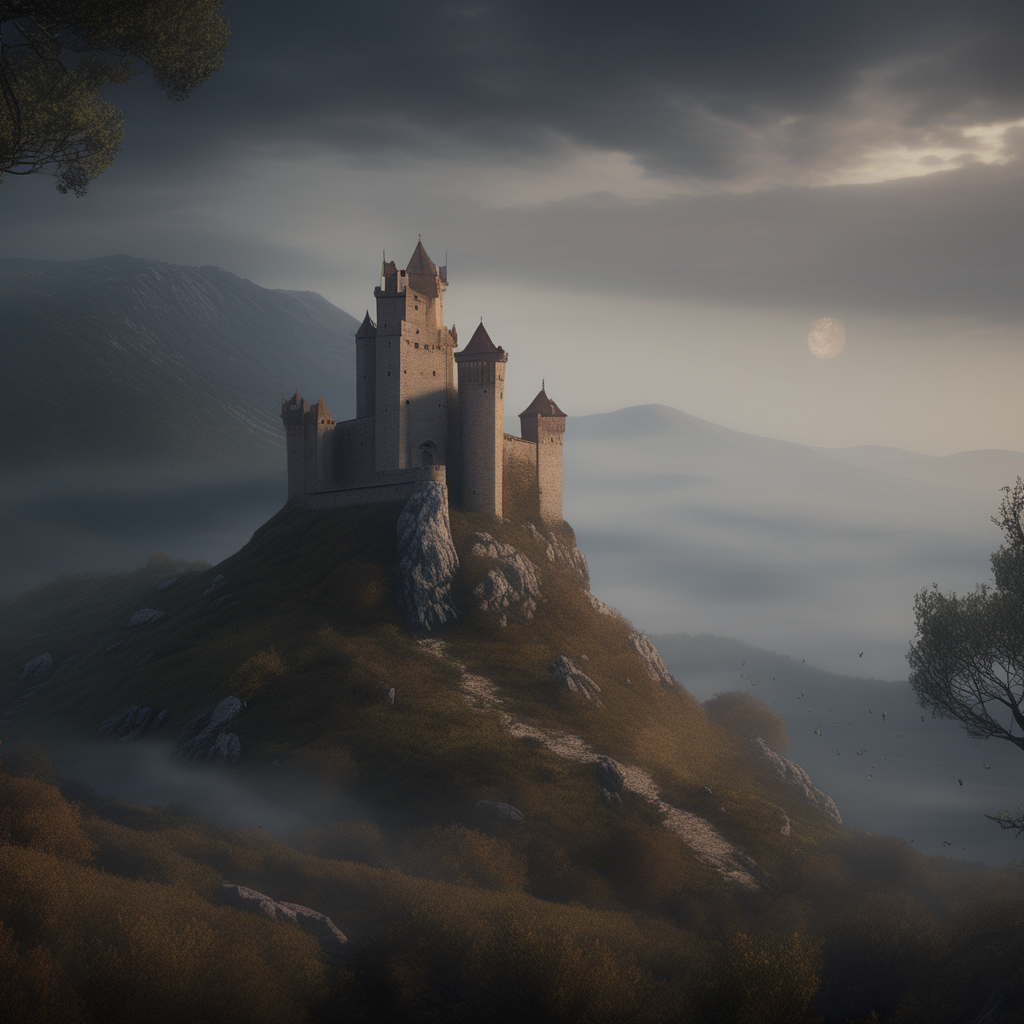

In [1]:
# Importaciones necesarias
import torch
import gc
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler

# Cargar el modelo
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionXLPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    variant="fp16"
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")
pipe.enable_attention_slicing()

def generar_imagen(prompt, estilo, archivo_salida="imagen.png"):
    prompt_mejorado = (
        f"Generar una imagen en estilo {estilo.lower()}, altamente detallada y sin errores anatómicos. "
        f"La imagen debe representar lo siguiente: {prompt}. "
        f"Iluminación natural, alta resolución, texturas realistas."
    )
    with torch.no_grad():
        resultado = pipe(prompt_mejorado, guidance_scale=8.0, num_inference_steps=50)
        imagen = resultado.images[0]
    imagen.save(archivo_salida)
    del imagen
    torch.cuda.empty_cache()
    gc.collect()
    return archivo_salida

# Código para probar en Google Colab
prompt = "Un castillo medieval en la cima de una montaña rodeado de niebla"
estilo = "realista"
archivo_generado = generar_imagen(prompt, estilo)
from IPython.display import display
from PIL import Image
display(Image.open(archivo_generado))

# Extra - Link para Sad Talker (Codigo funcional de demo)
(https://colab.research.google.com/github/Winfredy/SadTalker/blob/main/quick_demo.ipynb#scrollTo=ToBlDusjK5sS)

In [11]:
import os
from pydub import AudioSegment

def generar_deepface():


    # Definir rutas absolutas
    base_path = "/content/SadTalker"  # Ajusta esto según tu estructura de carpetas
    mp3_path = "/content/audio.mp3"
    wav_path = "/content/audio.wav"
    img_path = "/content/default_talking_head.png"

    # Convertir MP3 a WAV
    AudioSegment.from_mp3(mp3_path).export(wav_path, format="wav")

    # Cambiar al directorio SadTalker
    os.chdir(base_path)

    # Ejecutar el script
    !python3.8 inference.py \
      --driven_audio {wav_path} \
      --source_image {img_path} \
      --result_dir ./results \
      --still \
      --preprocess full \
      --enhancer gfpgan

    os.chdir("/content")

# Llamar a la función
generar_deepface()

# Cambiar al directorio SadTalker



using safetensor as default
3DMM Extraction for source image
landmark Det:: 100% 1/1 [00:00<00:00, 14.39it/s]
3DMM Extraction In Video:: 100% 1/1 [00:00<00:00, 23.60it/s]
mel:: 100% 1251/1251 [00:00<00:00, 40332.02it/s]
audio2exp:: 100% 126/126 [00:00<00:00, 353.84it/s]
Face Renderer:: 100% 626/626 [06:10<00:00,  1.69it/s]
The generated video is named ./results/2025_03_24_00.07.15/default_talking_head##audio.mp4
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
seamlessClone:: 100% 1251/1251 [20:20<00:00,  1.02it/s]
The generated video is named ./results/2025_03_24_00.07.15/default_talking_head##audio_full.mp4
face enhancer....
Face Enhancer:: 100% 1251/1251 [21:04<00:00,  1.01s/it]
The generated video is named ./results/2025_03_24_00.07.15/default_talking_head##audio_enhanced.mp4
The generated video is named: ./results/2025_03_24_00.07.15.mp4


# Extra - Fondo de Imagen

In [9]:

import numpy as np
from PIL import Image
import gradio as gr

def hex_to_bgr(color_str):
    """
    Convierte una cadena de color a una tupla en formato BGR.
    Soporta:
    - Hexadecimal (e.g., "#ff0000")
    - rgb()/rgba() (e.g., "rgb(255, 0, 0)" o "rgba(255, 0, 0, 1)")
    - Nombres de colores básicos (e.g., "red", "blue", etc.)
    """
    if color_str.startswith('#'):
        # Si es hexadecimal
        color_str = color_str.lstrip('#')
        r = int(color_str[0:2], 16)
        g = int(color_str[2:4], 16)
        b = int(color_str[4:6], 16)
        return (b, g, r)
    elif color_str.startswith('rgb'):
        # Si es formato "rgb(...)" o "rgba(...)"
        color_str = color_str.strip()
        if color_str.startswith("rgba"):
            # Extrae los valores ignorando el alfa
            numbers = color_str[5:-1].split(',')
        else:
            numbers = color_str[4:-1].split(',')
        # Convertir cada valor primero a float y luego a int (para manejar decimales)
        numbers = [int(float(x.strip())) for x in numbers[:3]]
        r, g, b = numbers
        return (b, g, r)
    else:
        # Fallback: si se pasa un nombre de color, usar un diccionario básico
        colors = {
            'red': '#ff0000',
            'green': '#00ff00',
            'blue': '#0000ff',
            'yellow': '#ffff00',
            'black': '#000000',
            'white': '#ffffff'
        }
        if color_str.lower() in colors:
            return hex_to_bgr(colors[color_str.lower()])
        else:
            raise ValueError("Formato de color no reconocido: " + color_str)

def create_frame(color_str, height=480, width=640):
    # Convierte el color de entrada a una tupla en formato BGR
    color_bgr = hex_to_bgr(color_str)
    # Crea un frame (arreglo NumPy) del tamaño indicado y lo rellena con el color en BGR
    frame = np.full((height, width, 3), color_bgr, dtype=np.uint8)
    # Convierte el frame de BGR a RGB para visualizarlo correctamente
    frame_rgb = frame[..., ::-1]
    # Retorna la imagen como objeto PIL
    return Image.fromarray(frame_rgb)

iface = gr.Interface(
    fn=create_frame,
    inputs=gr.ColorPicker(label="Selecciona el color de fondo del video"),
    outputs="image",
    flagging_mode="never"  # Evita guardar datos en .gradio/flagged/dataset1.csv
)

iface.launch()




Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b88772c71a1b5c0d40.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
